## Содержание

## Библиотеки

In [1]:
import os
from time import strftime

import torch
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.tensorboard import SummaryWriter

import dataset.custom_datasets as cust_ds
import dataset.default_augmentations as def_augs
import dataset.test_dataset as test_cl_ds

from models.triplet_loss import TripletLossModel, ClassificationForTLModel
import model_test.classify_model_test as class_m_test
from model_selection.metrics import CustomAccuracy, F1Score
import tools.tl_base_callback as tl_call

In [2]:
datasets_path = 'G:\\diplom\\project\\triplet_loss_project_2_06.04\\data'
train_ds_path = os.path.join(datasets_path, 'sampled_train_marks_models')
test_ds_path = os.path.join(datasets_path, 'sampled_test')

In [3]:
def marks_indx_f(x):
    return (x[0],)


def models_indx_f(x):
    return (x[0], x[1])

## 1. Модель классификации

**Тест датасета**

In [4]:
classif_ds_train = cust_ds.TLClassifyDataset(
    train_ds_path, marks_indx_f, crop=False,
    transform=def_augs.clTL_train_augs_128
)

classif_ds_test = cust_ds.TLClassifyDataset(
    test_ds_path, marks_indx_f, crop=False,
    transform=def_augs.clTL_test_augs_128
)

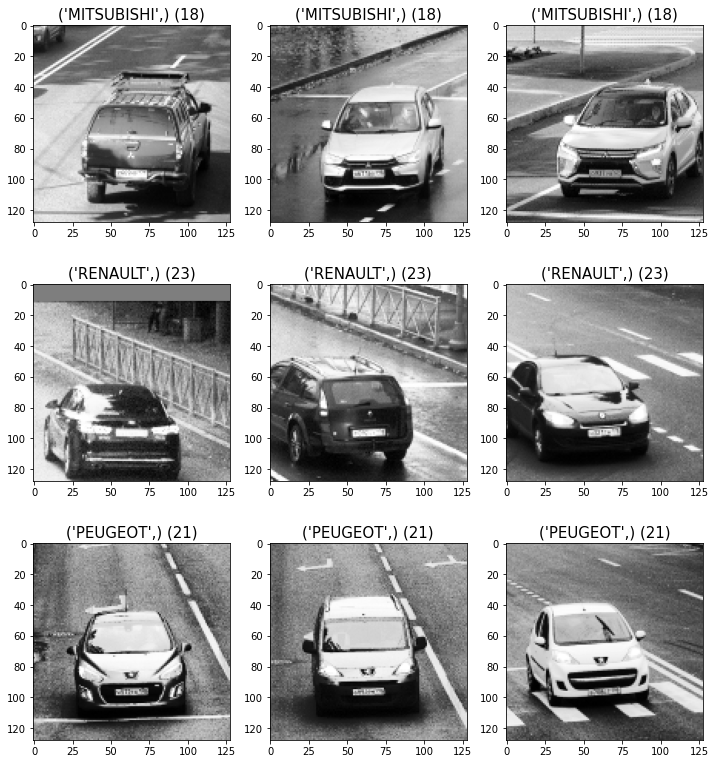

In [5]:
test_cl_ds.classify_ds_test(classif_ds_test, n_rows=3,
                            lines_span=1.5, figsize_sq=3)

**Тест модели**

In [6]:
mark_classes_n = len(classif_ds_train.labels_code)
class_mark_model = ClassificationForTLModel(mark_classes_n)

Визуальный:

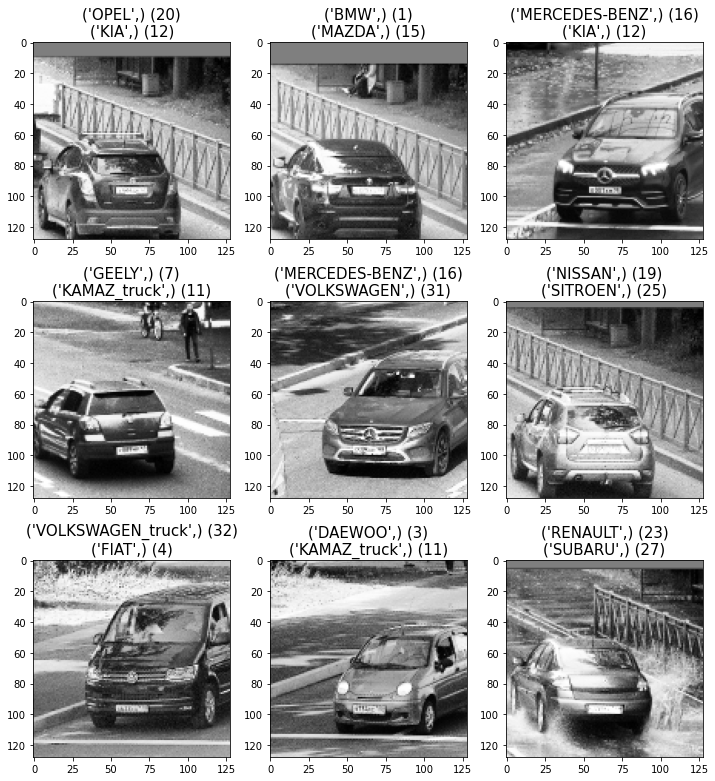

In [7]:
n_rows = 3

t = class_m_test.test_classif_model(class_mark_model,
                                    classif_ds_test,
                                    n_rows=n_rows)

test_cl_ds.classify_ds_test(classif_ds_test, n_rows=n_rows,
                            lines_span=1.5, figsize_sq=3,
                            imgs_indexes=t[0], add_to_title=t[1])

Accuracy

In [8]:
acc = CustomAccuracy()

In [9]:
acc_bef_learn = acc.ds_scope(classif_ds_test, class_mark_model)

  0%|          | 0/167 [00:00<?, ?it/s]

In [10]:
print(f'Accuracy модели до обучения: {round(acc_bef_learn, 3)}')

Accuracy модели до обучения: 0.043


f1 score

In [11]:
f1_score = F1Score()

In [12]:
f1_score_bef_learn = f1_score.ds_scope(classif_ds_test, class_mark_model)

  0%|          | 0/167 [00:00<?, ?it/s]

In [13]:
print(f'f1 score модели до обучения: {round(f1_score_bef_learn, 3)}')

f1 score модели до обучения: 0.004


**Обучение модели**

In [14]:
criterion = CrossEntropyLoss()
optimizer = Adam(class_mark_model.parameters(), lr=0.0001,
                 betas=(0.9, 0.999), eps=1e-08,
                 weight_decay=0, amsgrad=False)

class_mark_model.compile_settings(criterion, optimizer)

C:\Users\ski6a\anaconda3\envs\cv_env\lib\site-packages\torch\cuda\__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [15]:
current_time = strftime('%d-%m_%H-%M-%S')
# logdir = f'runs2/{current_time}'
# os.makedirs(logdir)
# writer = SummaryWriter(log_dir=logdir)

loss_function = CrossEntropyLoss()
delimeter=20
w_filepaths = ['weights/1. classify for triplet loss/conv2Dfeatures.pt',
               'weights/1. classify for triplet loss/fully_connect.pt']

callback = tl_call.ClassifyCallBack(writer, classif_ds_test,
                                    loss_function, delimeter,
                                    w_filepaths)

In [34]:
w_filepaths_load = [
    'weights/1. classify for triplet loss/1. 240 epochs/conv2Dfeatures.pt',
    'weights/1. classify for triplet loss/1. 240 epochs/fully_connect.pt'
]

class_mark_model.split_load(w_filepaths_load)

In [18]:
epochs = 10000
# class_mark_model.fit(classif_ds_train, epochs, callback=callback)

In [19]:
acc_aft_learn = acc.ds_scope(classif_ds_test, class_mark_model)
print(f'Accuracy модели после обучения: {round(acc_aft_learn, 3)}')

  0%|          | 0/167 [00:00<?, ?it/s]

Accuracy модели после обучения: 0.468


In [20]:
f1_score_aft_learn = f1_score.ds_scope(classif_ds_test, class_mark_model)
print(f'f1 score модели до обучения: {round(f1_score_aft_learn, 3)}')

  0%|          | 0/167 [00:00<?, ?it/s]

f1 score модели до обучения: 0.363


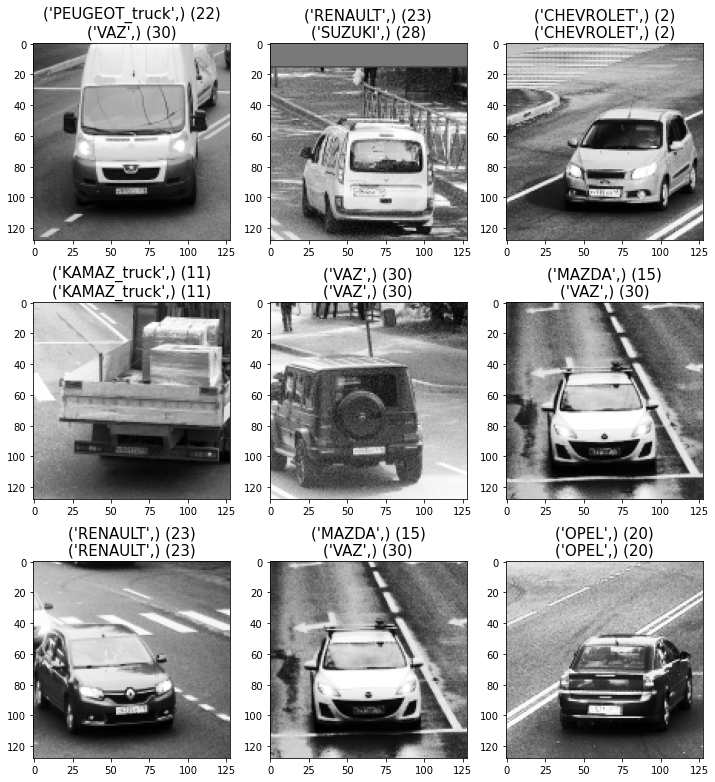

In [42]:
n_rows = 3

t = class_m_test.test_classif_model(class_mark_model,
                                    classif_ds_test,
                                    n_rows=n_rows)

test_cl_ds.classify_ds_test(classif_ds_test, n_rows=n_rows,
                            lines_span=1.5, figsize_sq=3,
                            imgs_indexes=t[0], add_to_title=t[1])

## 2. Модель Triplet Loss

**Тест датасета**

In [15]:
tl_ds_train = cust_ds.TripletLossDataset(
    train_ds_path, marks_indx_f, length = 100,
    crop=False, transform=def_augs.clTL_test_augs_128
)

In [16]:
tl_ds_train[0]

{'Anc': tensor([[[-0.9813, -1.1038, -1.0894,  ..., -1.3020, -1.1867, -1.0642],
          [-1.3886, -1.2480, -1.2624,  ..., -1.3345, -1.2948, -1.4390],
          [-0.9236, -1.3165, -1.5399,  ..., -1.0714, -0.9416, -0.8695],
          ...,
          [ 0.7525,  0.7020,  0.6515,  ...,  1.1525,  1.0768,  1.0913],
          [ 0.9831,  0.9038,  0.7849,  ...,  0.9074,  1.1057,  0.9543],
          [ 0.9615,  0.9795,  1.0732,  ...,  1.7653,  1.7653,  1.7653]]]),
 'Pos': tensor([[[-0.0369, -0.0369, -0.0369,  ..., -0.0369, -0.0369, -0.0369],
          [-0.0369, -0.0369, -0.0369,  ..., -0.0369, -0.0369, -0.0369],
          [-0.0369, -0.0369, -0.0369,  ..., -0.0369, -0.0369, -0.0369],
          ...,
          [ 0.5542,  0.5110,  0.6696,  ...,  0.2587,  0.1505,  0.1830],
          [ 0.6659,  0.2695,  0.5218,  ...,  0.0316,  0.0748,  0.0280],
          [ 0.4100,  0.4605,  0.6804,  ...,  0.1469,  0.4064,  0.1613]]]),
 'Neg': tensor([[[ 1.0624,  0.5398,  0.6840,  ..., -0.0730,  0.1938,  0.0460],
       

In [ ]:
# Перепиши Triplet Loss без разделения ракурса

# Разделение ракурса будет докручено отдельно

In [ ]:
# Это в classify_dataset.py: + нужно переиментовать файл в custom_datasets
class DatasetForTripletLoss:
    def __init__(self,
                 ds_path: str,
                 index_func: Callable[[tuple], tuple],
                 length: int,
                 crop: bool = False,
                 transform: A.Compose = None):
        # length - количество триплетов в одной эпохе
        self.ds_len = length
        self.crop = crop
        self.transform = transform
        
        ds = collect_dataset(ds_path, index_func)
        images, labels, self.labels_code = ds
        self.blocks = collect_blocks(images, labels)
        self.blocks_range = range(len(self.blocks.keys()))
        
    def __len__(self):
        return self.ds_len
    
    def __getitem__(self, indx, img_meta: bool = False):
        ap_indx, n_indx = sample(self.blocks_range, 2)
        a_ip, p_ip = sample(self.blocks[ap_indx], 2)
        n_ip = choice(self.blocks[n_indx])
        sample = self.get_sample(a_ip, p_ip, n_ip)
        return sample
    
    def get_sample(
        a_ip: str, p_ip: str, n_ip: str, get_meta: bool
    ) -> dict:
        a_img_tens, p_img_tens, n_img_tens = self.proc_imgs(a_ip, p_ip, n_ip)
        if get_meta:
            anc_name, pos_name, neg_name = self.get_meta(a_ip, p_ip, n_ip)
            sample =  {'Anc': a_img_tens, 'Anc_n': anc_name,
                       'Pos': p_img_tens, 'Pos_n': pos_name,
                       'Neg': n_img_tens, 'Neg_n': neg_name}
        else:
            sample =  {'Anc': a_img_tens,
                       'Pos': p_img_tens,
                       'Neg': n_img_tens}
        return sample
    
    def proc_imgs(
        self, a_ip: str, p_ip: str, n_ip: str
    ) -> Tuple[torch.tensor, torch.tensor, torch.tensor]:
        a_array_img = img_proc.open_image(a_ip)
        p_array_img = img_proc.open_image(p_ip)
        n_array_img = img_proc.open_image(n_ip)
        if self.crop:
            a_array_img = img_proc.custom_crop(a_array_img)
            p_array_img = img_proc.custom_crop(p_array_img)
            n_array_img = img_proc.custom_crop(n_array_img)
        if self.transform is not None:
            # augs : ([0, 1] np img) --> ([0, 1] np img)
            # np img dims ~ (h,w,c)
            a_array_img = self.transform(image=a_array_img)['image']
            p_array_img = self.transform(image=p_array_img)['image']
            n_array_img = self.transform(image=n_array_img)['image']    
        a_img_tens = torch.permute(torch.FloatTensor(a_array_img), (2,0,1))
        p_img_tens = torch.permute(torch.FloatTensor(p_array_img), (2,0,1))
        n_img_tens = torch.permute(torch.FloatTensor(n_array_img), (2,0,1))
        return a_img_tens, p_img_tens, n_img_tens
        
    @staticmethod
    def get_meta(a_ip: str, p_ip: str, n_ip: str) -> Tuple[str, str, str]:
        csn = [os.path.split(os.path.split(a_ip)[0])[-1].split(' '),
               os.path.split(os.path.split(p_ip)[0])[-1].split(' '),
               os.path.split(os.path.split(n_ip)[0])[-1].split(' ')]
        cars_names = [f'{sn[0]}\n{sn[1]}\n{sn[-1][:4]}' for sn in csn]
        return tuple(cars_names)

In [50]:
t = classif_ds_test.images[0]
t

'G:\\diplom\\project\\triplet_loss_project_2_06.04\\data\\sampled_test\\AUDI A3 2011\\Y614TK178_0037_010.png'

['AUDI', 'A3', '2011']

In [48]:
from random import sample, choice

In [47]:
a,b = sample([1,2,3,4,5], 2)
a,b

(5, 4)

In [ ]:
TripletLossModel